# Modulos

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os
# import the relevant modules

from sklearn.cluster import KMeans
from Bio import SeqIO
import copy
import math
import glob

In [3]:
#notebook_path = os.path.abspath("./Python/variations.xls")


# Tratamento de Dados

Criar data frame e colocar primeira coluna como sample

In [4]:
raw_data = pd.read_excel(
    "../Python/variations.xls", sheet_name="variations")
    #"./projects/covid/variations.xls", sheet_name="variations")

raw_df = pd.DataFrame(raw_data)
raw_df.rename(columns={'Unnamed: 0': 'sample'}, inplace=True)
raw_df

,sample,REF,ALT,#
0,sample_5390,NaN,NaN,NaN
1,NaN,A,G,1.0
2,NaN,C,T,4.0
3,NaN,GGG,AAC,1.0
4,sample_5391,NaN,NaN,NaN
...,...,...,...,...
9965,NaN,GAGTTCAG,GG,1.0
9966,NaN,G,T,13.0
9967,NaN,TAA,TA,1.0
9968,NaN,T,C,3.0


preencher os valores NA da primeira coluna (sample) com os valores anteriores




In [5]:
raw_df['sample'].ffill(inplace=True)
raw_df
# test_df.tail(50)

,sample,REF,ALT,#
0,sample_5390,NaN,NaN,NaN
1,sample_5390,A,G,1.0
2,sample_5390,C,T,4.0
3,sample_5390,GGG,AAC,1.0
4,sample_5391,NaN,NaN,NaN
...,...,...,...,...
9965,sample_31308,GAGTTCAG,GG,1.0
9966,sample_31308,G,T,13.0
9967,sample_31308,TAA,TA,1.0
9968,sample_31308,T,C,3.0


Retirar valores NA das restantes colunas (Ref, Alt e #)

In [6]:
raw_df = raw_df.dropna(axis=0, how="any")
raw_df

#Como alternativa:
#data_no_na = test_df[['REF', 'ALT', '#']].apply(lambda x: pd.Series(x.dropna().values)) -> alternativa para remover os NAs


,sample,REF,ALT,#
1,sample_5390,A,G,1.0
2,sample_5390,C,T,4.0
3,sample_5390,GGG,AAC,1.0
5,sample_5391,A,G,1.0
6,sample_5391,C,T,4.0
...,...,...,...,...
9965,sample_31308,GAGTTCAG,GG,1.0
9966,sample_31308,G,T,13.0
9967,sample_31308,TAA,TA,1.0
9968,sample_31308,T,C,3.0


Usar `pivot` para colocar a coluna sample como index, as colunas REF e ALT passam para as primeiras 2 rows 

In [7]:
# final_data = raw_df.pivot(index="sample",
#                               columns=["REF", "ALT"], values=("#"))
# final_data.columns.name

final_df = (raw_df.set_index(['sample', 'REF', 'ALT'])
                ['#']
                .unstack(['REF', 'ALT'], fill_value=0)
                )
final_df

REF,A,C,GGG,C,T,G,AATGA,A,T,G,...,CTCGG,CTTAC,GCG,TTTAC,CCTG,CTG,TATGG,ATATGAGT,GTGTTTATTAC,TTCCATTTGGAAT
ALT,G,T,AAC,A,C,T,AA,T,A,A,...,GTCGT,TTTAG,TCA,TC,TCTT,ATT,TG,AT,ATGTTTAC,TT
sample,,,,,,,,,,,,,,,,,,,,,
sample_24115,4.0,16.0,0.0,1.0,3.0,11.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_24116,4.0,13.0,0.0,2.0,2.0,7.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_24117,4.0,14.0,0.0,2.0,2.0,8.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_24118,4.0,15.0,0.0,2.0,2.0,13.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_24119,4.0,16.0,0.0,1.0,3.0,12.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_6364,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample_6365,1.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
for column in final_df.columns[1:]:
	if sum(final_df[column]) < 10:
		final_df.drop([column], axis=1, inplace=True)

final_df

REF             A     C  GGG    C    T     G    A    T    G         T    A  \
ALT             G     T  AAC    A    C     T    T    A    A    C    G    C   
sample                                                                       
sample_24115  4.0  16.0  0.0  1.0  3.0  11.0  0.0  0.0  2.0  0.0  1.0  0.0   
sample_24116  4.0  13.0  0.0  2.0  2.0   7.0  1.0  0.0  2.0  0.0  1.0  0.0   
sample_24117  4.0  14.0  0.0  2.0  2.0   8.0  0.0  0.0  2.0  0.0  1.0  0.0   
sample_24118  4.0  15.0  0.0  2.0  2.0  13.0  0.0  0.0  2.0  0.0  1.0  0.0   
sample_24119  4.0  16.0  0.0  1.0  3.0  12.0  0.0  0.0  2.0  0.0  1.0  0.0   
...           ...   ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...   
sample_6364   1.0   5.0  1.0  0.0  0.0   0.0  1.0  0.0  0.0  0.0  0.0  0.0   
sample_6365   1.0   6.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0   
sample_6366   2.0   4.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
sample_6367   1.0   3.0  1.0  1.0  2.0   0.0  1.0  0.0  0.0  0.0  0.0  0.0   
sample_6368   1.0   4.0  1.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   

REF          CTGC    C AGATTTCA GAGTTCAG  TAA  GCT  CAG  
ALT          TTGT    G       AA       GG   TA  TCC  TAT  
sample                                                   
sample_24115  0.0  2.0      1.0      1.0  1.0  0.0  0.0  
sample_24116  0.0  2.0      1.0      1.0  1.0  0.0  0.0  
sample_24117  0.0  2.0      1.0      1.0  1.0  0.0  0.0  
sample_24118  0.0  2.0      1.0      1.0  1.0  0.0  0.0  
sample_24119  0.0  2.0      1.0      1.0  1.0  0.0  0.0  
...           ...  ...      ...      ...  ...  ...  ...  
sample_6364   0.0  0.0      0.0      0.0  0.0  0.0  0.0  
sample_6365   0.0  0.0      0.0      0.0  0.0  0.0  0.0  
sample_6366   0.0  0.0      0.0      0.0  0.0  0.0  0.0  
sample_6367   0.0  0.0      0.0      0.0  0.0  0.0  0.0  
sample_6368   0.0  0.0      0.0      0.0  0.0  0.0  0.0  

[1226 rows x 19 columns]

Guardar em excel



In [9]:
final_df.to_excel('final_df_new.xlsx')

# PCA analysis


* Centrar e fazer scaling aos dados
NOTA: Se as nossas amostras estivessem nas colunas, colocar `preprocessing.scale(final_data_2.T)` para fazer a transposiçao

In [30]:
scaled_data = preprocessing.scale(final_df) # Fazer scaling dos dados para que fique centrado (0,0) 
# Como alternativa podemos usar o seguinte código para centrar os dados:
# StandardScaler().fit_transform(final_data_2)

pca = PCA(n_components=2) #n_componentes=X onde X é o numero de PC que quermos colocar no spree plot
pca.fit(scaled_data)  # calcular loading scores e variaçao para cada PCA
pca_data = pca.transform(scaled_data)
pca_data

array([[ 3.31179534, -0.53120524],
       [ 3.16574688, -0.43945237],
       [ 3.10510757, -0.5434574 ],
       ...,
       [-2.73820545, -0.05880252],
       [-2.42293324, -0.26038052],
       [-3.30312631, -0.21198949]])

### Scree plot para ver quantas componentes devem estar presentes no plot final. Este plot é usado para determinar o numero de fatores/principal components para uma analise de PCA.

* Calcular % de variabilidade que cada PC tem

In [31]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
per_var


array([53.6,  6.2])

* Criar labels para cada PC (PC1, PC2, PC3...) tendo em conta o tamanho da variabilidade

In [32]:
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
labels


['PC1', 'PC2']

* Fazer plot do spree plot

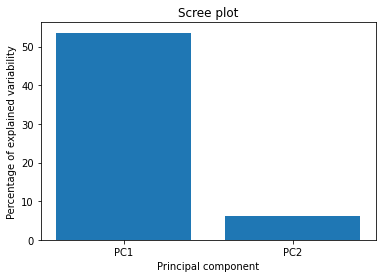

In [33]:
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of explained variability')
plt.xlabel('Principal component')
plt.title('Scree plot')
plt.show()  # grande parte da variabilidade está presente nos primeiros 9 componentes (cut-off point de 2). Estes 9 PC podem fazer uma boa representaçao geral dos dados

5. Colocar as principais coordenadas (9) numa data frame onde os rows são os samples e as colunas tem a PC label


In [34]:

#Guardar as labels das amostras numa variavel unica de modo a colocar como indice na data frame dos PCs
sample_labels = final_df.index

pca_df = pd.DataFrame(pca_data, index=[sample_labels], columns=labels)
pca_df

,PC1,PC2
sample,,
sample_24115,3.311795,-0.531205
sample_24116,3.165747,-0.439452
sample_24117,3.105108,-0.543457
sample_24118,3.494759,-0.561975
sample_24119,3.380050,-0.534516
...,...,...
sample_6364,-3.077477,-0.115226
sample_6365,-2.731334,-0.084672
sample_6366,-2.738205,-0.058803


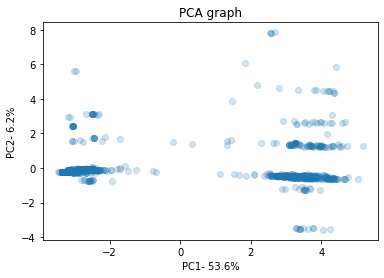

In [35]:


plt.scatter(pca_df.PC1, pca_df.PC2, alpha=0.2)
plt.title("PCA graph")
plt.xlabel('PC1- {0}%'.format(per_var[0]))
plt.ylabel('PC2- {0}%'.format(per_var[1]))
plt.show()


* KMeans clustering para identificar cluster (extrair os nossos clusters)


In [44]:
kmeans = KMeans(n_clusters=2, random_state=0) #como estamos a olhar para 2 PC, o n_clusters vai ser 2. O metodo 

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(pca_df)
X_clustered

array([1, 1, 1, ..., 0, 0, 0])

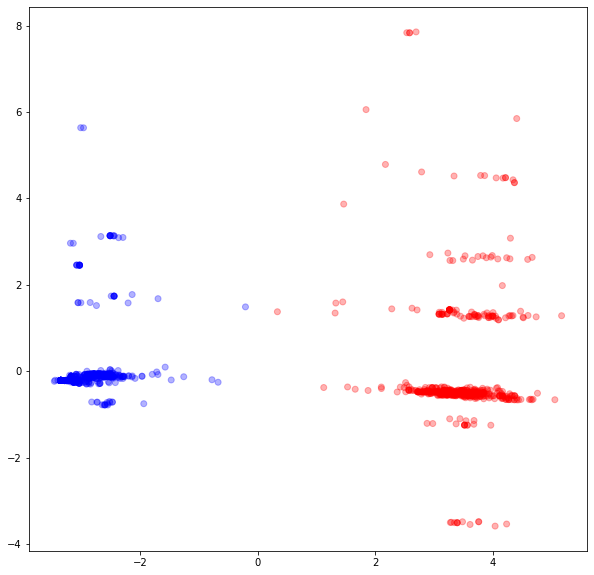

In [60]:
color_map = {0 : 'blue',
                   1 : 'red'} #alterar consoante o numero de componentes a analisar

label_color = [color_map[i] for i in X_clustered]
plt.figure(figsize = (10,10))
plt.scatter(pca_df.PC1,pca_df.PC2, c= label_color, alpha=0.3)
plt.show()


# Separar 20k sequencias em 5 ficheiros com ~ 4k


In [5]:
ids = pd.read_excel(
    "../Python/samples_ID.xlsx")

print(ids)

                      strain    lineage
0            Wuhan/Hu-1/2019          B
1         Portugal/CV62/2020      B.1.1
2         Portugal/CV63/2020        B.1
3       Portugal/PT0003/2020        B.1
4      Portugal/PT0001b/2020      B.1.1
...                      ...        ...
20105  Portugal/PT20090/2021      AY.43
20106  Portugal/PT20091/2021  B.1.617.2
20107  Portugal/PT20092/2021  B.1.617.2
20108  Portugal/PT20093/2021  B.1.617.2
20109  Portugal/PT20094/2021  B.1.617.2

[20110 rows x 2 columns]


In [ ]:
#Read fasta files with seqIO

for i in SeqIO.parse("sequences.fasta", "fasta"):
	#print(i.id)
	#print(str(i.seq)[11288:11296]) #deleçoes
	print(str(i.seq)) #deleçoes
	#print(len(i))
	break

records = list(SeqIO.parse("sequences.fasta", "fasta"))
len(records)

In [28]:

#Estes valores de x e y tem que estar fora do for loop caso contrario o x iria fazer reset para 0 a cada iteraçao e o y tambem fazia reset para 4030 a cada iteraçao
x = 0; #começar no 1º elemento da lista de records
y = 4030; #ir até ao 4000º elemento da lista de records

for i in range(1,6):
	SeqIO.write(records[x:y], "sequence_{id}.fasta".format(id=i), "fasta")
	x = y; #atualizar o valor de X com o ultimo valor de Y usado
	y += 4000; #adicionar 4000 ao y


#Tambem podiamos fazer de forma manual:
# SeqIO.write(records[0:4001], "sequences_01.fasta", "fasta")
# SeqIO.write(records[4001:8001], "sequences_02.fasta", "fasta")
# SeqIO.write(records[8001:12001], "sequences_03.fasta", "fasta")
# SeqIO.write(records[12001:16001], "sequences_04.fasta", "fasta")
# SeqIO.write(records[16001:], "sequences_05.fasta", "fasta")


* Concatenar ficheiros csv numa data frame



In [4]:
path = r'C:\Users\Rafael\Desktop\main\University\BioinformaticaClinica\1Semestre\FEM\Projeto\FEM\Python'
all_files = glob.glob(path + "/*.csv")
df_from_each_file = (pd.read_csv(f,sep=";") for f in all_files)
concatenated_df = pd.concat(df_from_each_file, ignore_index = True)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 3, saw 3


* Dataframe com dados que interessam (seqName, clade, substitutions, deletions insertions)

In [3]:

final_df=pd.read_csv("data_final.csv")
#final_df = concatenated_df.iloc[:,[0,1,13,14,15]] #selecionar colunas que interessam

final_df.to_csv(r'./data_final.csv', index= False, header=True)

pd.set_option('display.max_rows', 200) 
final_df.head(10)

,seqName,clade,substitutions,deletions,insertions
0,Wuhan/Hu-1/2019,19A,NaN,NaN,NaN
1,Portugal/CV62/2020,20B,"C241T,C3037T,C14408T,A23403G,C27046T,G28881A,G...",NaN,NaN
2,Portugal/CV63/2020,20A,"C241T,C3037T,C14408T,A23403G,C29144T",NaN,NaN
3,Portugal/PT0001b/2020,20B,"C241T,C3037T,C14408T,A23403G,C27046T,G28881A,G...",NaN,NaN
4,Portugal/PT0003/2020,20A,"C241T,C3037T,C14408T,A23403G,C29144T",NaN,NaN
5,Portugal/PT0004/2020,20A,"C241T,C3037T,C14408T,A23403G,C29144T",NaN,NaN
6,Portugal/PT0005/2020,20A,"C241T,C335T,C3037T,C14408T,G20398A,A23403G,A26...",NaN,NaN
7,Portugal/PT0006a/2020,20A,"C241T,C3037T,C14408T,A23403G,C29144T",NaN,NaN
8,Portugal/PT0006b/2020,20A,"C241T,C3037T,C14408T,A23403G,C28310T,C29144T,T...",NaN,NaN
9,Portugal/PT0007/2020,20B,"C241T,C3037T,C3373A,C14408T,A23403G,G28881A,G2...",NaN,NaN


# Contar substituições, inserções e deleções

## Substituições


In [87]:
# Criar nova data frame para colocar linhas como seqName / Clade e colunas como C-T, etc

pca_df = final_df.iloc[:,[0,1]]
pca_df
#A>T

,seqName,clade
0,Wuhan/Hu-1/2019,19A
1,Portugal/CV62/2020,20B
2,Portugal/CV63/2020,20A
3,Portugal/PT0001b/2020,20B
4,Portugal/PT0003/2020,20A
...,...,...
20105,Portugal/PT20090/2021,21J (Delta)
20106,Portugal/PT20091/2021,21J (Delta)
20107,Portugal/PT20092/2021,21J (Delta)
20108,Portugal/PT20093/2021,21J (Delta)


In [7]:
final_df

,seqName,clade,substitutions,deletions,insertions
0,Wuhan/Hu-1/2019,19A,NaN,NaN,NaN
1,Portugal/CV62/2020,20B,"C241T,C3037T,C14408T,A23403G,C27046T,G28881A,G...",NaN,NaN
2,Portugal/CV63/2020,20A,"C241T,C3037T,C14408T,A23403G,C29144T",NaN,NaN
3,Portugal/PT0001b/2020,20B,"C241T,C3037T,C14408T,A23403G,C27046T,G28881A,G...",NaN,NaN
4,Portugal/PT0003/2020,20A,"C241T,C3037T,C14408T,A23403G,C29144T",NaN,NaN
...,...,...,...,...,...
20105,Portugal/PT20090/2021,21J (Delta),"G210T,C241T,G2281T,C2358T,C3037T,G4181T,C6402T...","22029-22034,28248-28253,28271,29748-29774",NaN
20106,Portugal/PT20091/2021,21J (Delta),"G210T,C241T,C1593T,C3037T,G4181T,A5718G,C6402T...","21992-21994,22029-22034,28248-28253,28271",NaN
20107,Portugal/PT20092/2021,21J (Delta),"G210T,C241T,C745T,C3037T,G4181T,C6402T,C6730T,...","22029-22034,28248-28253,28271",NaN
20108,Portugal/PT20093/2021,21J (Delta),"G210T,C241T,C1593T,C3037T,G4181T,G4856T,A5718G...","21992-21994,22029-22034,28248-28253,28271",NaN


In [14]:
pca_df.iloc[0]

'Wuhan/Hu-1/2019'

In [18]:
final_df.columns[:]

Index(['seqName', 'clade', 'substitutions', 'deletions', 'insertions'], dtype='object')

In [24]:
pca_df.columns[:]

snv = "test"

if snv not in pca_df.columns[:]:
	pca_df.insert()



snv nao esta


In [72]:
final_df.iloc[1:4]

,seqName,clade,substitutions,deletions,insertions
1,Portugal/CV62/2020,20B,"C241T,C3037T,C14408T,A23403G,C27046T,G28881A,G...",NaN,NaN
2,Portugal/CV63/2020,20A,"C241T,C3037T,C14408T,A23403G,C29144T",NaN,NaN
3,Portugal/PT0001b/2020,20B,"C241T,C3037T,C14408T,A23403G,C27046T,G28881A,G...",NaN,NaN


In [ ]:
pca_df.iloc[1]
final_df.iloc[1]

pca_df.columns[:]
pca_df

In [97]:

for line in range(1,len(final_df)): #len(final_df)
	#print("Nova linha ########")

	substitutions = final_df.iloc[line,2] #substitutions vai dando reset a medida que vao atribuindo novos valores. /TODO: posso tentar passar isto para lista e fazer o loop por elemento de lista em vez de usar split(",")
	snv = [] #Criar nova lista por cada linha lida 

	#print(substitutions)
	#print(line)

	for content in substitutions.split(","):
		reference = content[0] #Obter o 1º character (a referencia)
		substitution = content[-1] #Obter o ultimo caracter (a substituiçao)
		output = "{0}>{1}".format(reference,substitution)
		pca_df
		snv.append(output)
		#print(snv)

	d = dict() #criar dicionario para fazer as contagens
	for key in snv:
		d[key] = d.get(key,0) + 1
	#print(d)

	for key,value in d.items():
		#print(key)
		#print(value)
		#if key not in pca_df.columns[:]:
		#	pca_df.from_dict(d)
		#print(line)
		#print(key)
		#print(value)
		pca_df.loc[line, key] = value



In [98]:
pca_df.head(100)

,seqName,clade,C>T,A>G,G>A,G>C,T>C,C>A,G>T,A>T,T>A,T>G,A>C,C>G
0,Wuhan/Hu-1/2019,19A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Portugal/CV62/2020,20B,4.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Portugal/CV63/2020,20A,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Portugal/PT0001b/2020,20B,4.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Portugal/PT0003/2020,20A,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Portugal/PT0004/2020,20A,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Portugal/PT0005/2020,20A,4.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Portugal/PT0006a/2020,20A,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Portugal/PT0006b/2020,20A,5.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Portugal/PT0007/2020,20B,3.0,1.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:

snv = []


for line in final_df:
	for content in line.split(","): #Por cada linha na final_df na coluna substitutions, usando como separador ",":
		print(reference)
		


		#Criar sequencia de 2 até ..
		for i in range(2,20111):
			if snv not in pca_df.columns[:]:
				pca_df.insert(i, snv, 1)
		# if snv not in pca_df.iloc[0,:]:
		# 		append 
		# else:
		# 		count snv[i] += 1		


pca_df

# for line in final_df:
# 	for content in final_df['substitutions']:
	#colocar o 1º carater na 1º linha
	#Colocar o ultimo carater na 2º linha
	#Se o 1º e ultimo caracter forem iguais, count += 1

C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


KeyboardInterrupt: 

## Deleções

In [157]:
#Em relaçao à ref, deleçao

record_dict = SeqIO.to_dict(SeqIO.parse("sequences.fasta", "fasta"))
print(str(record_dict["Wuhan/Hu-1/2019"].seq)[11287:11295])

#TCTGGTTTT

TCTGGTTT


In [ ]:
final_df['deletions']

#passar para int, replace "-" para ":"
if not var1 is None:
	continue


#for i in indice:
	#for j in each column content:
		#pos = ...


for i in "11288-11296,21765-21770,21992-21994".split(","):

	pos1 = int(i.split("-")[0]) - 1
	pos2 = int(i.split("-")[1]) - 1

	print(pos1)
	print(pos2) #colocar estes valores no slicing das posiçies para deleçoes 


## Inserções

In [ ]:
#Em relaçao a inserçao, 0 based (-1 em cada posiçao no slicing)
record_dict = SeqIO.to_dict(SeqIO.parse("sequences.fasta", "fasta"))
print(str(record_dict["Portugal/PT3927/2021"].seq)[11288:11296])

In [ ]:
print(final_df['insertions'][1])
#type(nextclade_2['insertions'][1])

if  math.isnan(final_df['insertions'][1]):
	print("NaN")
	continue
else:
	print("Not NaN")